In [1]:
from collections import defaultdict
from datetime import datetime
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

sns.set_theme(style="white")

In [2]:
torch.__version__

'1.13.0+cpu'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load data

In [4]:
user_df = pd.read_csv('data/movieLens100k_users.csv')

print(user_df.shape)
user_df.head()

(671, 1)


,userId
0,0
1,1
2,2
3,3
4,4


In [5]:
movie_df = pd.read_csv('data/movieLens100k_movies.csv')
movie_df.drop(columns=['plot', 'title'], axis=1, inplace=True)

print(movie_df.shape)
movie_df.head()

(9125, 26)


,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year,num_popular_actors,num_popular_directors
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,1.528928,5.144229,-0.876122,0.158905,2.943417,4.502288
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0.174897,1.394602,-0.058951,0.158905,1.228413,-0.218854
2,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905,-0.486591,-0.218854
3,3,0,0,0,0,1,0,0,1,0,...,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905,-0.486591,-0.218854
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905,1.228413,-0.218854


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   Action                 9125 non-null   int64  
 2   Adventure              9125 non-null   int64  
 3   Animation              9125 non-null   int64  
 4   Children               9125 non-null   int64  
 5   Comedy                 9125 non-null   int64  
 6   Crime                  9125 non-null   int64  
 7   Documentary            9125 non-null   int64  
 8   Drama                  9125 non-null   int64  
 9   Fantasy                9125 non-null   int64  
 10  Film-Noir              9125 non-null   int64  
 11  Horror                 9125 non-null   int64  
 12  IMAX                   9125 non-null   int64  
 13  Musical                9125 non-null   int64  
 14  Mystery                9125 non-null   int64  
 15  Roma

In [7]:
rating_df = pd.read_csv('data/movieLens100k_ratings.csv')

print(rating_df.shape)
rating_df.head()

(100004, 3)


,userId,movieId,rating
0,0,1815,2.0
1,0,1962,2.5
2,0,2380,1.0
3,0,2925,3.0
4,0,1515,4.0


In [8]:
assert not movie_df.isnull().values.any(), 'Null values in dataset!'

### Load pretrained user-embeddings

The user embeddings are calculated in the notebook `03_LinkPrediction_userEmbeddings.ipynb`. The final embeddings are stored as `.npy` and just loaded here. Also the plot embeddings and their reduced forms are loaded here.

In [9]:
user_embeddings = np.load('./data/np_user_embeddings_20221125.npy')
# user_embeddings = np.load('./data/np_user_embeddings_20221223.npy')

plot_embeddings_umap4 = np.load('./data/np_plot_embeddings_umap_4d.npy')
plot_embeddings_tsne2 = np.load('./data/np_plot_embeddings_tsne_2d.npy')

print('User embedding shape:', user_embeddings.shape)
print('Plot embedding shape (UMAP-4):', plot_embeddings_umap4.shape)
print('Plot embedding shape (t-SENE-2):', plot_embeddings_tsne2.shape)


User embedding shape: (671, 8)
Plot embedding shape (UMAP-4): (9125, 4)
Plot embedding shape (t-SENE-2): (9125, 2)


In [10]:
assert len(user_embeddings) == 671, 'User shape not as expected'
assert len(user_df) == 671, 'User shape not as expected'
assert len(movie_df) == 9125, 'Movie shape not as expected'
assert len(rating_df) == 100_004, 'Rating shape not as expected'

n_users = len(user_df)
n_movies = len(movie_df)

print(f'# Users: {n_users}\n# Movies: {n_movies}')

# Users: 671
# Movies: 9125


In [12]:
movie_df.shape

(9125, 26)

### Create Pytorch Geometric (heterogenious) Dataset

In [18]:
# pd.concat([movie_df, pd.DataFrame(plot_embeddings_tsne2)], axis=1)

In [23]:
def create_movie_df(df:pd.DataFrame, kind:str) -> pd.DataFrame:
    """ """
    if kind == 'no_plot_embedding':
        movie_df = df
    elif kind == 'umap4':
        movie_df = pd.concat([df, pd.DataFrame(plot_embeddings_umap4)], axis=1)
    elif kind == 'tsne2':
        movie_df = pd.concat([df, pd.DataFrame(plot_embeddings_tsne2)], axis=1)
    else:
        raise ValueError('kind must be either "no_plot_embedding", "umap4", or "tsne2"')

    return movie_df

movie_df_no_plot = create_movie_df(movie_df, kind='no_plot_embedding')
movie_df_tsne2 = create_movie_df(movie_df, kind='tsne2')
movie_df_umap4 = create_movie_df(movie_df, kind='umap4')

print('dataset_no_plot:', movie_df_no_plot.shape)
print('dataset_tsne2:', movie_df_tsne2.shape)
print('dataset_umap4:', movie_df_umap4.shape)

dataset_no_plot: (9125, 26)
dataset_tsne2: (9125, 28)
dataset_umap4: (9125, 30)


In [24]:
def create_dataset(movie_df:pd.DataFrame) -> dict:
    """ Creates a PyG HeteroData object."""

    x_user = torch.Tensor(user_embeddings)

    x_movie = movie_df.drop(columns=['movieId'], axis=1)
    x_movie = torch.Tensor(x_movie.values)

    edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
    edge_label = torch.Tensor(rating_df['rating'].values)

    data = HeteroData()
    data['user'].x = x_user
    data['movie'].x = x_movie

    data[('user', 'rates', 'movie')].edge_index = edge_index
    data[('user', 'rates', 'movie')].edge_label = edge_label

    data = ToUndirected()(data)
    del data[('movie', 'rev_rates', 'user')].edge_label

    return data

dataset_no_plot = create_dataset(movie_df_no_plot)
dataset_tsne2 = create_dataset(movie_df_tsne2)
dataset_umap4 = create_dataset(movie_df_umap4)


print('dataset_no_plot:', dataset_no_plot)
print('dataset_tsne2:', dataset_tsne2)
print('dataset_umap4:', dataset_umap4)



dataset_no_plot: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
dataset_tsne2: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 27] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
dataset_umap4: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 29] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)


### Train / Test Split

In [54]:
def train_test_split(data:dict, num_val:float=0.1, num_test:float=0.1):
    train_data, val_data, test_data = RandomLinkSplit(
        num_val=num_val,
        num_test=num_test,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)
    return train_data, val_data, test_data

### GNN Model

In [26]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        # x = self.norm2(x)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.00)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.dropout(z)
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


# model = Model(hidden_channels=32, out_channels=32).to(device)

In [27]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
def lazy_init(model, data):
    """ Due to lazy initialization, we need to run one model step 
        so the number of parameters can be inferred."""
    with torch.no_grad():
        model.encoder(data.x_dict, data.edge_index_dict)

In [28]:
# optimizer = torch.optim.Adam(model.parameters())


In [29]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    target = data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [65]:
do_cv = False

if do_cv:
    EPOCHS = 1000
    best_test_loss = 100
    save_date = datetime.today().strftime('%Y%m%d')
    train_losses, val_losses, test_losses = [], [], []
    results = {}
    for dataset, name in zip([dataset_no_plot, dataset_tsne2, dataset_umap4],
                            ['NoPlotEmbed', 'tSENE2', 'UMAP4']):
        print(dataset)
        data = dataset

        results[name] = {}
        results[name]['train_losses'] = []
        results[name]['val_losses'] = []
        results[name]['test_losses'] = []
        results[name]['time_elapsed'] = []
        
        # Cross validation
        for cv in range(1, 4):

            train_data, val_data, test_data = train_test_split(data)
            model = Model(hidden_channels=32, out_channels=32).to(device)
            optimizer = torch.optim.Adam(model.parameters())
            lazy_init(model=model, data=train_data)
            
            train_losses, val_losses, test_losses = [], [], []
            for epoch in range(1, EPOCHS+1):
                train_loss = train(model=model, data=train_data, optimizer=optimizer)
                val_loss = test(model=model, data=val_data)
                test_loss = test(model=model, data=test_data)

                train_losses.append(train_loss), val_losses.append(val_loss), test_losses.append(test_loss)

                if epoch % 100 == 0:
                    print(f'\tTraining CV #{cv}\tepoch # {epoch}\ttrain_loss: {train_loss:.3f}' \
                        f'\tval_loss: {val_loss:.3f}\ttest_loss: {test_loss:.3f}')

            results[name]['train_losses'].append(train_losses)
            results[name]['val_losses'].append(val_losses)
            results[name]['test_losses'].append(test_losses)

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
	Training CV #1	epoch # 100	train_loss: 0.969	val_loss: 0.994	test_loss: 0.995
	Training CV #1	epoch # 200	train_loss: 0.916	val_loss: 0.947	test_loss: 0.949
	Training CV #1	epoch # 300	train_loss: 0.869	val_loss: 0.890	test_loss: 0.899
	Training CV #1	epoch # 400	train_loss: 0.863	val_loss: 0.879	test_loss: 0.890
	Training CV #1	epoch # 500	train_loss: 0.860	val_loss: 0.876	test_loss: 0.886
	Training CV #1	epoch # 600	train_loss: 0.859	val_loss: 0.875	test_loss: 0.884
	Training CV #1	epoch # 700	train_loss: 0.858	val_loss: 0.874	test_loss: 0.882
	Training CV #1	epoch # 800	train_loss: 0.858	val_loss: 0.873	test_loss: 0.882
	Training CV #1	epoch # 900	train_loss: 0.857	val_loss: 0.872	test_loss: 0.881
	Training CV #1	epoch # 1000	train_loss: 0.856	val_loss: 0.872	test_loss: 0.881
	Training 

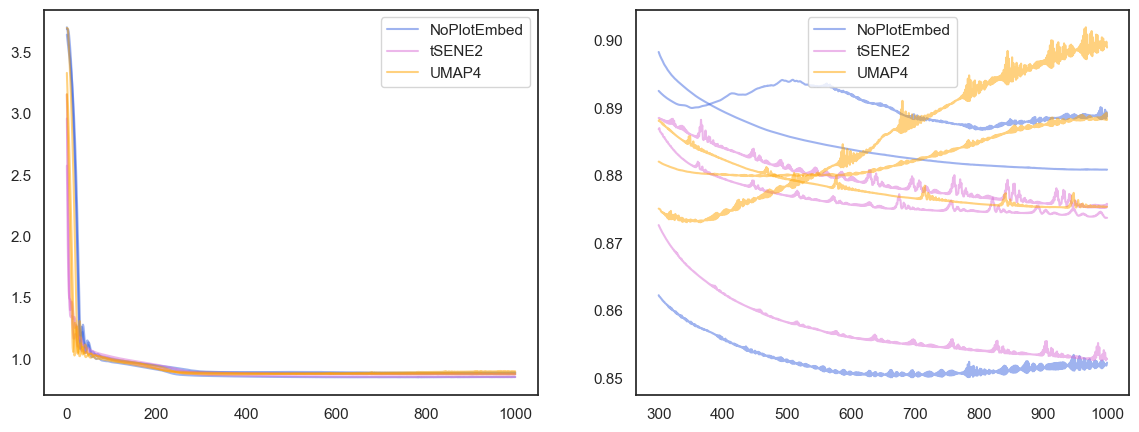

In [67]:
OFFSET = 300
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
color_list = ['royalblue', 'orchid', 'orange'] #limegreen, 'yellow', 'cyan'
assert len(results) == len(color_list)

for model, color in zip(results.keys(), color_list):
    # print(model)
    train_losses = results[model]['train_losses']
    test_losses = results[model]['test_losses']
    for i, test_loss in enumerate(test_losses):
        # print(i)
        if i == 0:
            ax0.plot(test_loss, label=model, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], label=model, c=color, alpha=0.5)
        else:
            ax0.plot(test_loss, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], c=color, alpha=0.5)

ax0.legend()
ax1.legend()
plt.show()

In [68]:
do_train = False

if do_train:
    EPOCHS = 600
    best_test_loss = 100
    save_date = datetime.today().strftime('%Y%m%d')
    train_losses, val_losses, test_losses = [], [], []
    cv_results = {}
    cv_results['train_losses'] = []
    cv_results['val_losses'] = []
    cv_results['test_losses'] = []

    # train_data, val_data, test_data = train_test_split(dataset_umap4)
    # train_data, val_data, test_data = train_test_split(dataset_tsne2)
    train_data, val_data, test_data = train_test_split(dataset_no_plot)
    model = Model(hidden_channels=24, out_channels=24).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    lazy_init(model=model, data=train_data)

    train_losses, val_losses, test_losses = [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss = train(model=model, data=train_data, optimizer=optimizer)
        val_loss = test(model=model, data=val_data)
        test_loss = test(model=model, data=test_data)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # print to console
        if epoch % 100 == 0:
            print(f'\tEpoch # {epoch}\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}\ttest_loss: {test_loss:.3f}')

            # safe best model
            if test_loss < best_test_loss:
                torch.save(model, f'./models/sage_model_{save_date}')
                best_test_loss = test_loss

    cv_results['train_losses'].append(train_losses)
    cv_results['test_losses'].append(test_losses)

    # save results as json
    cv_results_json = json.dumps(cv_results, indent=4)
    with open(f'models/sage_model_{save_date}_results.json', 'w') as f:
        f.write(cv_results_json)

	Epoch # 100	train_loss: 0.990	val_loss: 1.004	test_loss: 0.991
	Epoch # 200	train_loss: 0.909	val_loss: 0.931	test_loss: 0.914
	Epoch # 300	train_loss: 0.859	val_loss: 0.886	test_loss: 0.863
	Epoch # 400	train_loss: 0.855	val_loss: 0.881	test_loss: 0.858
	Epoch # 500	train_loss: 0.853	val_loss: 0.879	test_loss: 0.858
	Epoch # 600	train_loss: 0.851	val_loss: 0.878	test_loss: 0.858


In [79]:
# Load best model
model = torch.load('models/sage_model_20230108')
test_loss = test(model=model, data=test_data)
print(test_loss)

# Load model results
with open('models/sage_model_20230108_results.json') as json_file:
    model_results = json.load(json_file)

0.8576915264129639


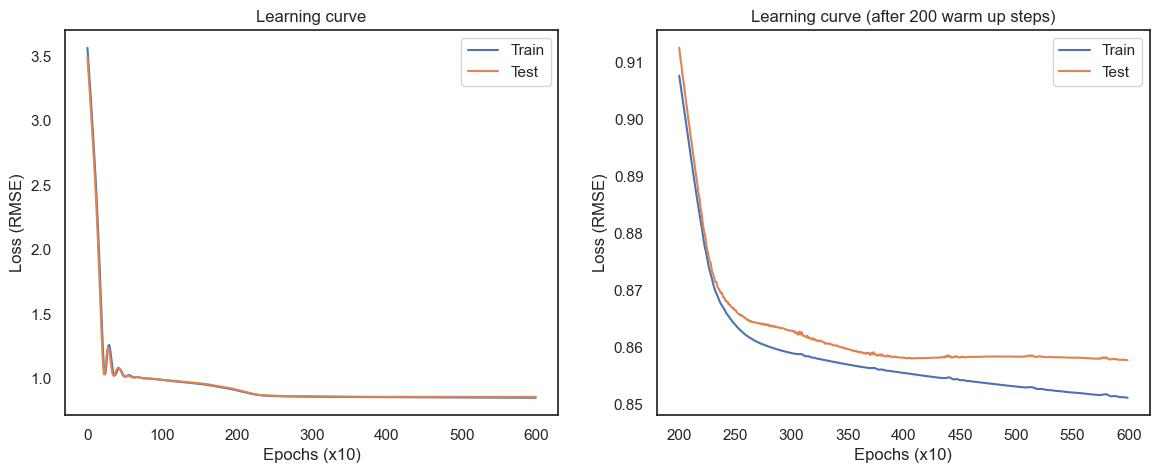

In [85]:
SKIP_WARM_UP_STEPS = 200

train_losses = model_results['train_losses'][0]
test_losses = model_results['test_losses'][0]

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(test_losses, label='Test')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs (x10)')
ax0.set_ylabel('Loss (RMSE)')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(test_losses)), test_losses[SKIP_WARM_UP_STEPS:], label='Test')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs (x10)')
ax1.set_ylabel('Loss (RMSE)')
ax1.legend()
plt.show()

### Inspect test results

In [86]:
model.eval()
pred = model(test_data.x_dict, test_data.edge_index_dict,
                test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)
target = test_data['user', 'movie'].edge_label.float()
rmse = F.mse_loss(pred, target).sqrt()

In [87]:
pred[:20], target[:20]

(tensor([2.9724, 3.9992, 3.6889, 3.5172, 3.2797, 3.5268, 4.4963, 3.5764, 3.3550,
         4.0056, 4.0984, 3.8702, 4.0096, 2.5478, 3.1185, 2.8566, 2.9420, 3.0568,
         3.4057, 2.8790], grad_fn=<SliceBackward0>),
 tensor([5.0000, 3.0000, 4.5000, 3.0000, 2.5000, 4.0000, 5.0000, 3.0000, 3.0000,
         4.0000, 4.5000, 4.0000, 5.0000, 3.0000, 3.5000, 2.0000, 3.0000, 4.0000,
         3.5000, 3.5000]))

#### Evaluation

Mean squared Error (MSE) can be used as loss function. However, it is not a well suited metric to evaluate the model's recommendations. `Recall@k` fits better for evaluating the recommendations done by the model.  

In [92]:
def create_rec_dict_per_user() -> dict:
    """ Return a dictionnairy, with link predictions for each user.
    
        The dict keys are userId's and values a list of tuples. The
        first tuple value is the predicted rating and the second one
        the ground truth (rating). """

    user_rec_dict = defaultdict(list)
    test_users_unique = test_data['user', 'movie'].edge_label_index[0].unique()

    with torch.no_grad():
        for user_id in tqdm(test_users_unique):
            user_id = user_id.item()

            idxs = (test_data['user', 'movie'].edge_label_index[0] == user_id).nonzero().squeeze()
            edge_idxs = test_data['user', 'movie'].edge_label_index[:,idxs]
            
            true_ratings = test_data['user', 'movie'].edge_label[idxs]
            if true_ratings.ndimension() == 0:
                true_ratings = test_data['user', 'movie'].edge_label[idxs].unsqueeze(dim=0)

            pred_ratings = model(test_data.x_dict, test_data.edge_index_dict, edge_idxs)

            ratings = [(pred.item(), gt.item()) for gt, pred in zip(true_ratings, pred_ratings)] 
            user_rec_dict[user_id] = ratings
        
        return user_rec_dict


def recall_precision_at_k(user_rec_dict:dict, k:int, threshold:float) -> dict:
    """" """
    with torch.no_grad():
        precisions = dict()
        recalls = dict()


        for uid, user_ratings in user_rec_dict.items():
            
            user_ratings.sort(key=lambda x: x[0], reverse=True) 
             
            n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
            n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])
            n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
            
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        return recalls, precisions

user_rec_dict = create_rec_dict_per_user()

100%|██████████| 651/651 [00:30<00:00, 21.09it/s]


In [93]:
# k = 20
# threshold = 4.0
# recalls = recall_at_k(user_rec_dict, k, threshold)
# rcl_at_k = sum(recalls.values()) / len(recalls.values())
# print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

# threshold = 3.5
# recalls = recall_at_k(user_rec_dict, k=k, threshold=threshold)
# rcl_at_k = sum(recalls.values()) / len(recalls.values())
# print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

k = 20
threshold = 4.0
recalls, precisions = recall_precision_at_k(user_rec_dict, k, threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
prc_at_k = sum(precisions.values()) / len(precisions.values())

print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))
print(f'Precision@{k} (Threshold={threshold}):', round(prc_at_k, 4))

threshold = 3.5
recalls, precisions = recall_precision_at_k(user_rec_dict, k=k, threshold=threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
prc_at_k = sum(precisions.values()) / len(precisions.values())

print(f'\nRecall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))
print(f'Precision@{k} (Threshold={threshold}):', round(prc_at_k, 4))

Recall@20 (Threshold=4.0): 0.3486
Precision@20 (Threshold=4.0): 0.3782

Recall@20 (Threshold=3.5): 0.6644
Precision@20 (Threshold=3.5): 0.7238


### Get new recommendations

Get the top recommendended movies for each user and create new relationships `(m:Movie)-[:RECOMMENDED_TO]-> (u:User)` in Neo4j

In [95]:
K = 20
movie_recs = []
with open('data/encoder_user.pkl', 'rb') as pkl:
    user_encoder = pickle.load(pkl)

with open('data/encoder_movie.pkl', 'rb') as pkl:  
    movie_encoder = pickle.load(pkl)

with torch.no_grad():
    for user_id in tqdm(range(0, n_users)):
        user_row = torch.tensor([user_id] * n_movies)
        # break
        all_movie_ids = torch.arange(n_movies)
        edge_label_index = torch.stack([user_row, all_movie_ids], dim=0)
        pred = model(data.x_dict, data.edge_index_dict,
                edge_label_index)
        pred = pred.clamp(min=0, max=5)
        
        pred_top_k, pred_top_k_idxs = torch.topk(pred, k=K)
        
        movie_recs.append({
            'user': user_id,
            'user_id_neo4j': user_encoder.inverse_transform([user_id])[0],
            'rec_movie_ids': pred_top_k_idxs.tolist(), 
            'rec_movie_ids_neo4j': movie_encoder.inverse_transform(pred_top_k_idxs).tolist(),
            'pred_rating': pred_top_k.tolist()})

# safe recommendation dictionnariy
with open(f'./data/movie_recommendations_{save_date}', 'wb') as fp:   #Pickling
    pickle.dump(movie_recs, fp)

100%|██████████| 671/671 [00:30<00:00, 22.00it/s]


In [50]:
def create_recommendedTo_relationships(movie_recommendations:list) -> None:
    """ Creates relationships :RECOMMENDED_TO between movies and users.
        movie_recommendations (list): List of dicts with keys:
            user (int)
            user_id_neo4j (int)
            rec_movie_ids (list)
            rec_movie_ids_neo4j (list)
            pred_rating (list). 
    """
    with driver.session() as session:
        for rec in tqdm(movie_recs):

            user_id = rec['user_id_neo4j']
            rec_movie_ids = rec['rec_movie_ids_neo4j']
            query = f"""
            MATCH (u:User) 
            MATCH (m:Movie)
            WHERE u.userId = {user_id}
            AND m.movieId IN {rec_movie_ids}
            MERGE (m) -[:RECOMMENDED_TO]-> (u)
            ;
            """

            result = session.run(query)

In [105]:
with open('./data/movie_recommendations', 'rb') as fp:   # Unpickling
    movie_recs = pickle.load(fp)

create_recommendedTo_relationships(movie_recs)

100%|██████████| 671/671 [01:26<00:00,  7.80it/s]
